In [2]:
'''
author: EdgardoCS @FSU Jena
date: 18.06.2025
'''

# install openpyxl
import bambi as bmb
import arviz as az
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.genmod as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

In [4]:
input_data = 'output/data_sorted.xlsx'
columns = ['Id', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])

In [5]:
# Define all factor levels
c1 = ['Self', 'Other']
c2 = ['Front', 'Back']
c3 = ['Armpits', 'Chest', 'Feet', 'Hair', 'Hands', 'Legs', 'Mouth', 'Neck', 'Pelvis']
c4 = ['Male', 'Female']

In [6]:
# Unique subjects
ids = data['Id'].unique()

# Build full grid for each subject × all combinations of the 4 factors
all_combos = pd.DataFrame([
    (i, g, t, l, s)
    for i in ids
    for g, t, l, s in itertools.product(c4, c1, c2, c3)
], columns=['Id', 'Gender', 'Type', 'Location', 'Segment'])

# Add indicator of whether that combination was rated
data['Marked'] = (data['Rating'] > 0).astype(int)

# Merge data with all possible combinations
merged = all_combos.merge(
    data[['Id', 'Gender', 'Type', 'Location', 'Segment', 'Marked']],
    on=['Id', 'Gender', 'Type', 'Location', 'Segment'],
    how='left'
)

# Fill missing with 0 = not marked
merged['Marked'] = merged['Marked'].fillna(0).astype(int)

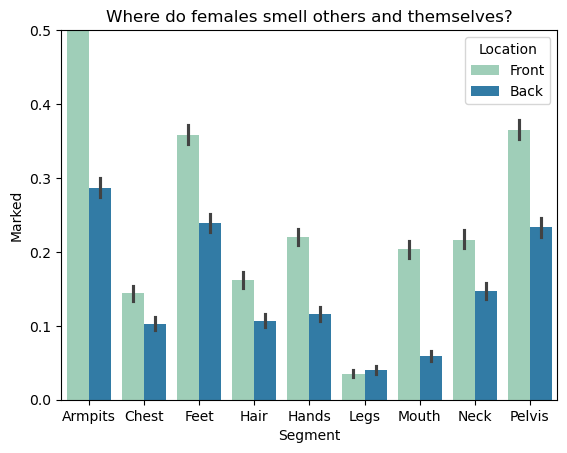

Text(0.5, 1.0, 'Where do males smell others and themselves?')

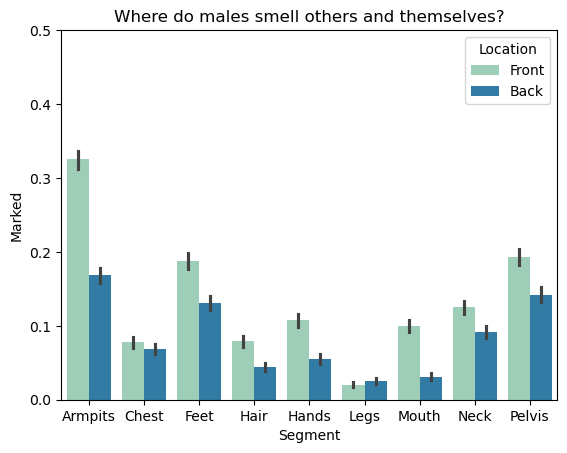

In [7]:
female = merged[merged['Gender'] == 'Female'].copy()
male = merged[merged['Gender'] == 'Male'].copy()

sns.barplot(
    data=female,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 0.5)
plt.title('Where do females smell others and themselves?')

plt.show()
sns.barplot(
    data=male,
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 0.5)
plt.title('Where do males smell others and themselves?')

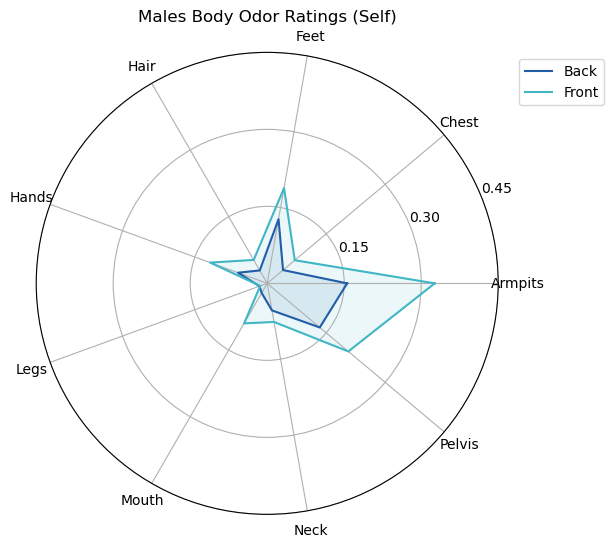

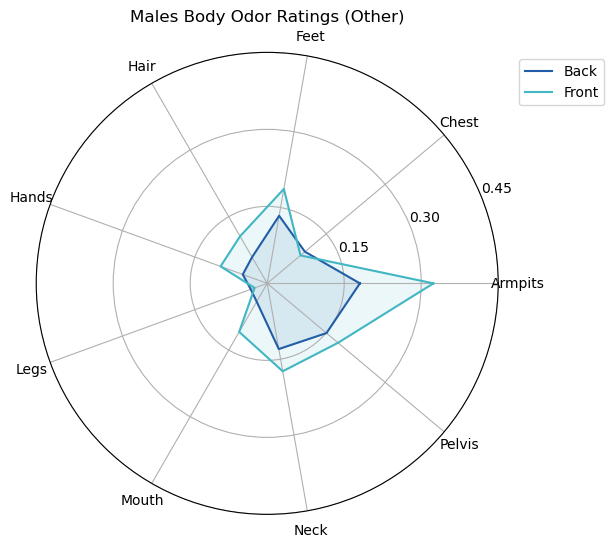

In [8]:
grouped = male.groupby(['Segment', 'Location', 'Type'])['Marked']
estimates = grouped.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})
# print(estimates)

types = ['Self', 'Other']
colors = ['#41b6c4', '#225ea8']

for i, t in enumerate(types):
    pivot_df = estimates[estimates['Type'] == t].pivot(
        index='Location',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Front":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Back":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.15, 0.30, 0.45]

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Males Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-male-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

In [9]:
# Logistic mixed-effects model
model = smf.glm(
    "Marked ~ Segment * Gender * Location * Type",
    data=merged,
    family=sm.families.Binomial()
)
result = model.fit()
# print(result.summary())


# Reference: Female, Others, armpit
# Intercept -0,7939, p < 0.001  (***)

# Location (front)  1,145,  p < 0.001 (***)
# Type (Self)       -0,246, p < 0.001 (***)
# Gender (Male)     -0,718, p < 0.001 (***)
# β, p
# Segment[T.chest]  -0,9682,    p < 0.001 (***)
# Segment[T.feet]   -0,2593,    p < 0.001(***)
# Segment[T.hair]   -1,0679,    p < 0.001 (***)
# Segment[T.hand]   -1,3846,    p < 0.001 (***)
# Segment[T.legs]   -2,0947,    p < 0.001 (***)
# Segment[T.mouth]  -1,6987,    p < 0.001 (***)
# Segment[T.neck]   -0,4887,    p < 0.001(***)
# Segment[T.pelvis] -0,2789,    p < 0.001 (***)

# Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower with the exception of the feet.
# All segments were rated significantly higher in front
# There is a four-way interaction for type (self, other)(p < 0.001), gender(female, male)(p < 0.001), and location(front, back)(p < 0.001) for ratings of body segments.

In [10]:
# 1. Is there any difference between Female and Male when smelling Others?
target = (merged[
              (merged['Type'] == 'Other') &
              (merged['Gender'].isin(['Female', 'Male']))]
          .copy())
# same model, only for type others
model = smf.mixedlm(
    "Marked ~ Segment * Location * Gender",
    merged,
    groups=merged["Id"]
)
result1 = model.fit()

print(result1.summary())

C:\Users\silva\AppData\Local\anaconda3\envs\bodyOdors\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Marked     
No. Observations:              173448              Method:                         REML       
No. Groups:                    2409                Scale:                          0.1136     
Min. group size:               72                  Log-Likelihood:                 -59127.7138
Max. group size:               72                  Converged:                      Yes        
Mean group size:               72.0                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.286    0.005  56.935 0.00

In [11]:
check = pd.crosstab([merged['Segment'], merged['Location']], merged['Marked'])

In [ ]:
model = bmb.Model("Marked ~ Segment + Location", data=male, family="bernoulli")

# Fit with NUTS sampling (MCMC)
results = model.fit(draws=2000, chains=4)

az.summary(results)

# Since this is a logistic model, coefficients are in log-odds.
#  Intercept: -1.421

# Compared to the armpits, all segments have lower odds of being marked by factor (mean)
# Location (front) has an increase of odds of being marked compared to back (0,74)
# Odds ratio = e^0.555 ≈ 1.74 ⇒ Being on the front makes it ~74% more likely to be marked.

In [ ]:
model = bmb.Model("Marked ~ Segment + Type", data=male, family="bernoulli")

# Fit with NUTS sampling (MCMC)
results = model.fit(draws=2000, chains=4)

az.summary(results)

# Since this is a logistic model, coefficients are in log-odds.
#  Intercept: -1.421

# Compared to the armpits, all segments have lower odds of being marked by factor (mean)
# Location (front) has an increase of odds of being marked compared to back (0,74)
# Odds ratio = e^0.555 ≈ 1.74 ⇒ Being on the front makes it ~74% more likely to be marked.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

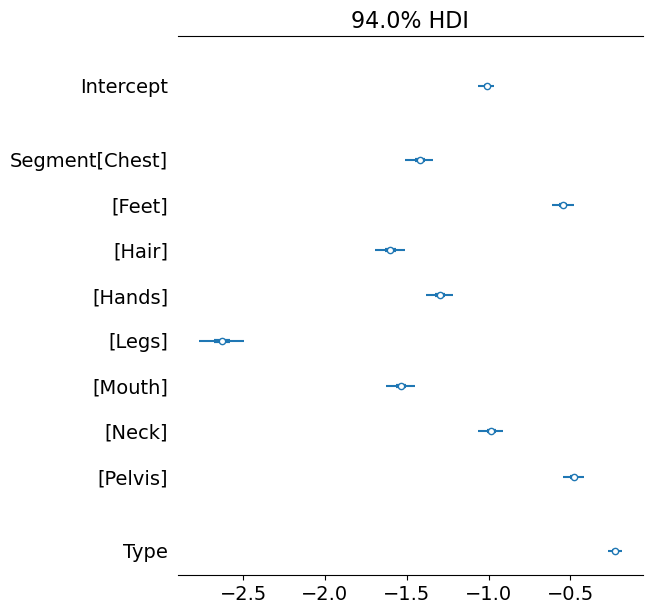

In [23]:
az.plot_forest(results, kind="forestplot", combined=True)
# az.plot_trace(results)
# az.plot_posterior(results)